| 구분                | 데이터 개수  | 컬럼 구성                           | 비고    |
| ----------------- | ------- | ------------------------------- | ----- |
| Train             | 12,457개 | fname, dialogue, summary, topic | 학습용   |
| Dev               | 499개    | fname, dialogue, summary, topic | 검증용   |
| Test              | 500개    | fname, dialogue (요약문 없음!)       | 제출용   |
| Sample Submission | 500개    | fname, summary                  | 제출 형식 |


In [11]:
# 1. 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from transformers import AutoTokenizer, MBart50TokenizerFast
from collections import Counter
import re

# 시스템에 설치된 폰트 목록
font_list = [f.name for f in fm.fontManager.ttflist]
korean_fonts = [f for f in font_list if 'Gothic' in f or 'Nanum' in f or 'Malgun' in f or 'Apple' in f or 'Noto' in f]
print("사용 가능한 한글 폰트:")
print(set(korean_fonts))

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Noto Sans CJK JP'  # 또는 'Noto Sans CJK JP'
plt.rcParams['axes.unicode_minus'] = False

사용 가능한 한글 폰트:
{'Noto Sans CJK JP', 'Noto Serif CJK JP'}


In [12]:
# 2. 데이터 불러오기
train = pd.read_csv('train.csv')
dev = pd.read_csv('dev.csv')
test = pd.read_csv('test.csv')

print("=" * 50)
print("데이터 기본 정보")
print("=" * 50)
print(f"Train 데이터 크기: {train.shape}")
print(f"Dev 데이터 크기: {dev.shape}")
print(f"Test 데이터 크기: {test.shape}")
print("\nTrain 데이터 샘플:")
print(train.head(3))
print("\n컬럼 정보:")
print(train.info())


데이터 기본 정보
Train 데이터 크기: (12457, 4)
Dev 데이터 크기: (499, 4)
Test 데이터 크기: (499, 2)

Train 데이터 샘플:
     fname                                           dialogue  \
0  train_0  #Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다...   
1  train_1  #Person1#: 안녕하세요, Mrs. Parker. 잘 지내셨나요?\n#Pers...   
2  train_2  #Person1#: 저기요, 열쇠 세트 본 적 있어요?\n#Person2#: 어떤 ...   

                                             summary  topic  
0  Mr. Smith는 Dr. Hawkins에게 건강검진을 받으러 와서, 매년 검진 필...   건강검진  
1  Mrs. Parker가 Ricky와 함께 백신 접종을 위해 방문하였고, Dr. Pe...  백신 접종  
2  #Person1#은 열쇠 세트를 잃어버리고 #Person2#에게 찾는 것을 도와달라...  열쇠 분실  

컬럼 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fname     12457 non-null  object
 1   dialogue  12457 non-null  object
 2   summary   12457 non-null  object
 3   topic     12457 non-null  object
dtypes: object(4)
memory usage: 389.4+ KB
None


In [13]:
# 3. 텍스트 길이 분석
train['dialogue_len'] = train['dialogue'].astype(str).apply(len)
train['summary_len'] = train['summary'].astype(str).apply(len)
train['dialogue_word_count'] = train['dialogue'].astype(str).apply(lambda x: len(x.split()))
train['summary_word_count'] = train['summary'].astype(str).apply(lambda x: len(x.split()))

print("\n" + "=" * 50)
print("텍스트 길이 통계")
print("=" * 50)
print("\n대화문(dialogue) 길이 통계:")
print(train['dialogue_len'].describe())
print("\n요약문(summary) 길이 통계:")
print(train['summary_len'].describe())
print("\n대화문 단어 수 통계:")
print(train['dialogue_word_count'].describe())
print("\n요약문 단어 수 통계:")
print(train['summary_word_count'].describe())



텍스트 길이 통계

대화문(dialogue) 길이 통계:
count    12457.000000
mean       406.083487
std        197.566083
min         84.000000
25%        280.000000
50%        369.000000
75%        500.000000
max       2165.000000
Name: dialogue_len, dtype: float64

요약문(summary) 길이 통계:
count    12457.000000
mean        85.789436
std         33.811948
min         13.000000
25%         61.000000
50%         80.000000
75%        104.000000
max        376.000000
Name: summary_len, dtype: float64

대화문 단어 수 통계:
count    12457.000000
mean        84.464478
std         43.613074
min         17.000000
25%         56.000000
50%         75.000000
75%        106.000000
max        508.000000
Name: dialogue_word_count, dtype: float64

요약문 단어 수 통계:
count    12457.000000
mean        16.480694
std          7.015613
min          4.000000
25%         11.000000
50%         15.000000
75%         20.000000
max         75.000000
Name: summary_word_count, dtype: float64


In [14]:
# 4. 토픽 분포 분석
print("\n" + "=" * 50)
print("토픽 분포")
print("=" * 50)
topic_counts = train['topic'].value_counts()
print(f"\n전체 토픽 개수: {len(topic_counts)}")
print(f"\n상위 20개 토픽:")
print(topic_counts.head(20))


토픽 분포

전체 토픽 개수: 9235

상위 20개 토픽:
topic
음식 주문       130
취업 면접       109
길 안내         66
호텔 체크인       40
아파트 임대       30
일상 대화        29
쇼핑           27
주말 계획        26
면접           25
호텔 예약        25
여행 계획        23
항공권 예약       22
영화 감상        21
작별 인사        21
휴가 계획        21
가격 협상        20
택시 이용        20
영화 관람 계획     18
의료 상담        16
파티 초대        16
Name: count, dtype: int64


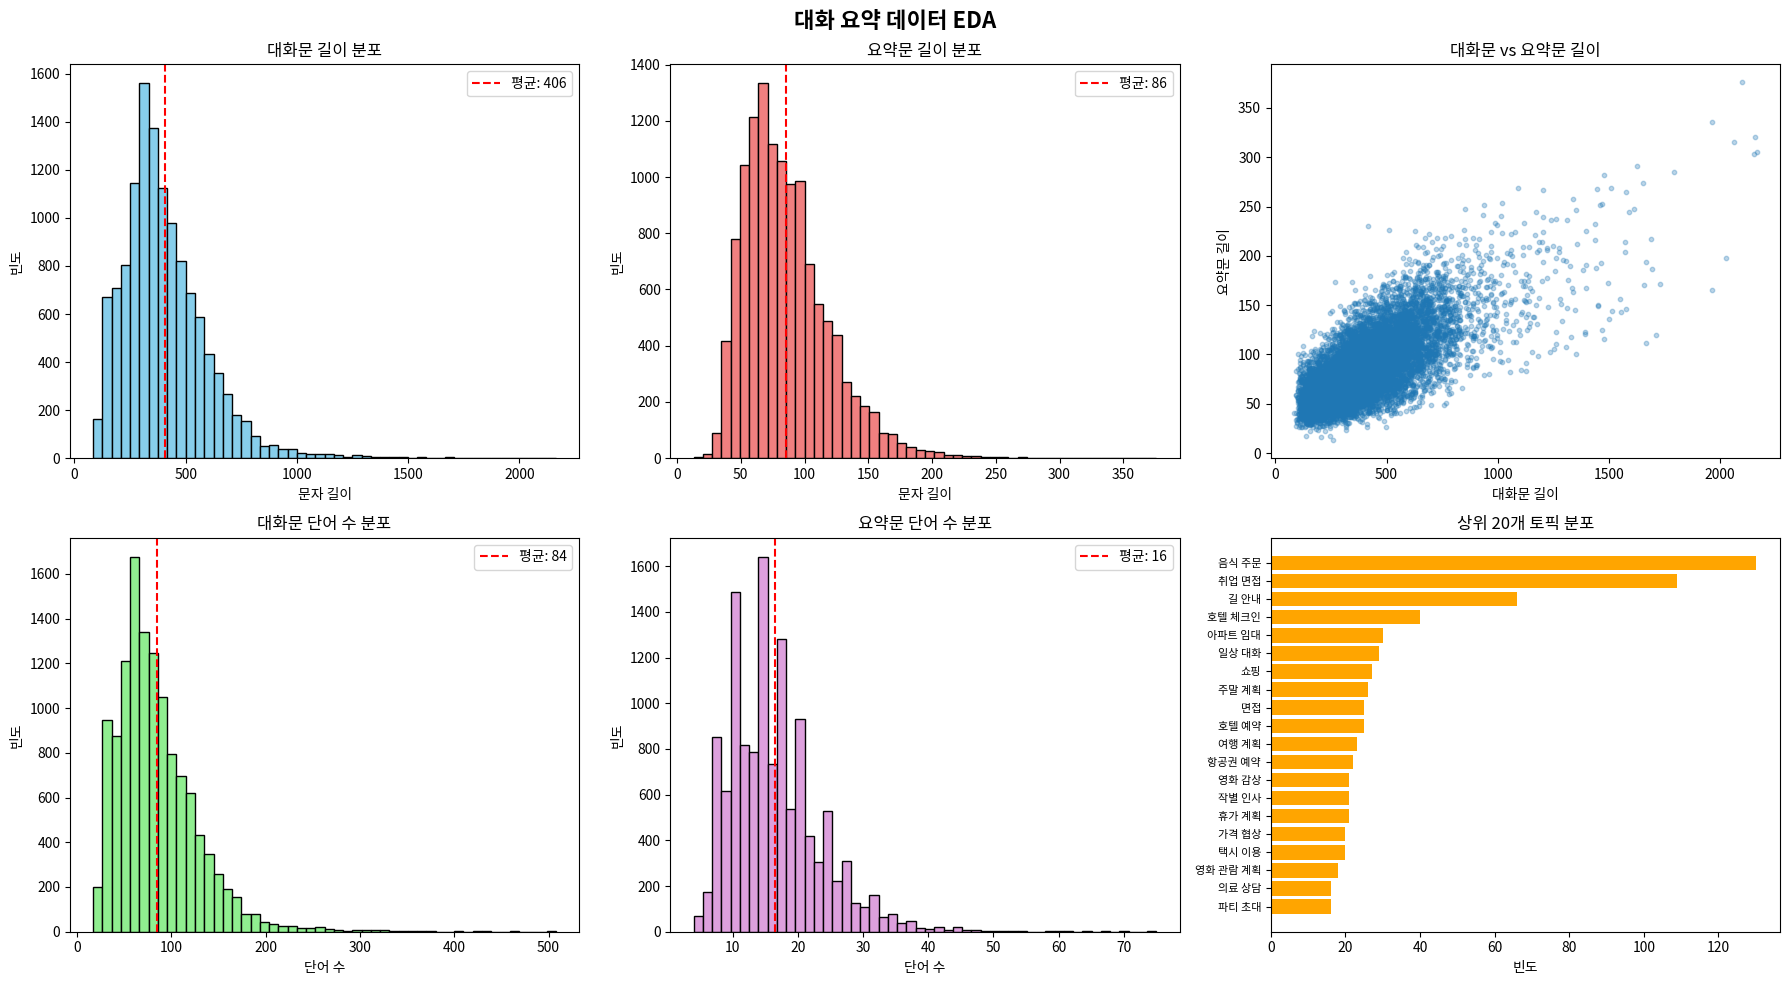


시각화 완료!


In [15]:
# 5. 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('대화 요약 데이터 EDA', fontsize=16, fontweight='bold')

# 5-1. 대화문 길이 분포
axes[0, 0].hist(train['dialogue_len'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('대화문 길이 분포')
axes[0, 0].set_xlabel('문자 길이')
axes[0, 0].set_ylabel('빈도')
axes[0, 0].axvline(train['dialogue_len'].mean(), color='red', linestyle='--', label=f'평균: {train["dialogue_len"].mean():.0f}')
axes[0, 0].legend()

# 5-2. 요약문 길이 분포
axes[0, 1].hist(train['summary_len'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('요약문 길이 분포')
axes[0, 1].set_xlabel('문자 길이')
axes[0, 1].set_ylabel('빈도')
axes[0, 1].axvline(train['summary_len'].mean(), color='red', linestyle='--', label=f'평균: {train["summary_len"].mean():.0f}')
axes[0, 1].legend()

# 5-3. 대화문 vs 요약문 길이 산점도
axes[0, 2].scatter(train['dialogue_len'], train['summary_len'], alpha=0.3, s=10)
axes[0, 2].set_title('대화문 vs 요약문 길이')
axes[0, 2].set_xlabel('대화문 길이')
axes[0, 2].set_ylabel('요약문 길이')

# 5-4. 대화문 단어 수 분포
axes[1, 0].hist(train['dialogue_word_count'], bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('대화문 단어 수 분포')
axes[1, 0].set_xlabel('단어 수')
axes[1, 0].set_ylabel('빈도')
axes[1, 0].axvline(train['dialogue_word_count'].mean(), color='red', linestyle='--', label=f'평균: {train["dialogue_word_count"].mean():.0f}')
axes[1, 0].legend()

# 5-5. 요약문 단어 수 분포
axes[1, 1].hist(train['summary_word_count'], bins=50, color='plum', edgecolor='black')
axes[1, 1].set_title('요약문 단어 수 분포')
axes[1, 1].set_xlabel('단어 수')
axes[1, 1].set_ylabel('빈도')
axes[1, 1].axvline(train['summary_word_count'].mean(), color='red', linestyle='--', label=f'평균: {train["summary_word_count"].mean():.0f}')
axes[1, 1].legend()

# 5-6. 상위 20개 토픽 분포
top_topics = topic_counts.head(20)
axes[1, 2].barh(range(len(top_topics)), top_topics.values, color='orange')
axes[1, 2].set_yticks(range(len(top_topics)))
axes[1, 2].set_yticklabels(top_topics.index, fontsize=8)
axes[1, 2].set_title('상위 20개 토픽 분포')
axes[1, 2].set_xlabel('빈도')
axes[1, 2].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n시각화 완료!")


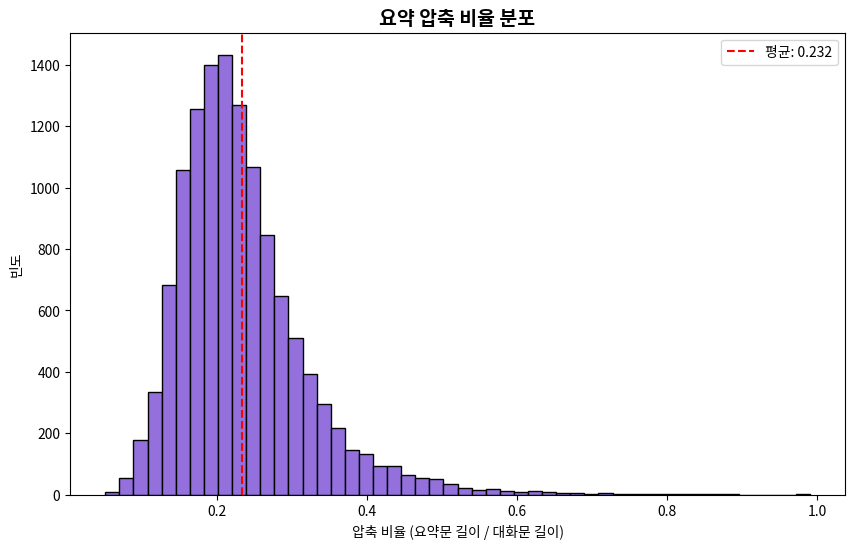


평균 압축 비율: 0.232
중간값 압축 비율: 0.217


In [16]:
# 6. 요약 비율 분석
train['compression_ratio'] = train['summary_len'] / train['dialogue_len']

plt.figure(figsize=(10, 6))
plt.hist(train['compression_ratio'], bins=50, color='mediumpurple', edgecolor='black')
plt.title('요약 압축 비율 분포', fontsize=14, fontweight='bold')
plt.xlabel('압축 비율 (요약문 길이 / 대화문 길이)')
plt.ylabel('빈도')
plt.axvline(train['compression_ratio'].mean(), color='red', linestyle='--', 
            label=f'평균: {train["compression_ratio"].mean():.3f}')
plt.legend()
plt.show()

print(f"\n평균 압축 비율: {train['compression_ratio'].mean():.3f}")
print(f"중간값 압축 비율: {train['compression_ratio'].median():.3f}")


In [17]:
# 7. 결측치 확인
print("\n" + "=" * 50)
print("결측치 확인")
print("=" * 50)
print(train.isnull().sum())


결측치 확인
fname                  0
dialogue               0
summary                0
topic                  0
dialogue_len           0
summary_len            0
dialogue_word_count    0
summary_word_count     0
compression_ratio      0
dtype: int64


| 항목         | Right Skewed 고려 X   | Right Skewed 고려 O      |
| ---------- | ------------------- | ---------------------- |
| Max Length | 평균 또는 최대값 사용        | 95 percentile 사용       |
| 데이터        | 모든 데이터 사용           | 99 percentile 이상 제거 고려 |
| Padding    | Static (max_length) | Dynamic (배치별)          |
| 평가         | 전체 평균만              | 길이별 구간 평가              |

| 상황                  | 추천 모델     | 이유              |
| ------------------- | --------- | --------------- |
| 영어 이름/단어 많음(현재 상황)  | mBART-50⭐ | 코드 스위칭 처리 우수    |
| GPU 메모리 부족 (< 12GB) | KoBART    | 모델 크기 작음 (124M) |
| 순수 한국어만 있음          | KoBART    | 한국어 성능 최고       |
| 다양한 언어 혼재           | mBART-50  | 50개 언어 지원       |

In [18]:
# 샘플 텍스트
sample_text = """#Person1#: 안녕하세요, Christine입니다. Mr. Brown과 약속이 있어요.
#Person2#: 네, Jack이 안내해드릴게요. Hilton Hotel로 가시면 됩니다."""

print("=" * 60)
print("토크나이저 비교 테스트")
print("=" * 60)

# 1. KoBART
print("\n[KoBART 토크나이저]")
kobart_tokenizer = AutoTokenizer.from_pretrained("gogamza/kobart-base-v2")
kobart_tokens = kobart_tokenizer(sample_text)
kobart_decoded = kobart_tokenizer.tokenize(sample_text)
print(f"토큰 수: {len(kobart_tokens['input_ids'])}")
print(f"샘플 토큰 (처음 25개):")
print(kobart_decoded[:25])

# 2. mBART-50 (수정된 버전)
print("\n[mBART-50 토크나이저]")
# MBartTokenizer 대신 MBart50TokenizerFast 사용
mbart_tokenizer = MBart50TokenizerFast.from_pretrained(
    "facebook/mbart-large-50",
    src_lang="ko_KR",
    tgt_lang="ko_KR"
)
mbart_tokens = mbart_tokenizer(sample_text)
mbart_decoded = mbart_tokenizer.tokenize(sample_text)
print(f"토큰 수: {len(mbart_tokens['input_ids'])}")
print(f"샘플 토큰 (처음 25개):")
print(mbart_decoded[:25])

# 3. 효율성 비교
print("\n" + "=" * 60)
print("토큰 효율성 비교")
print("=" * 60)
print(f"KoBART:  {len(kobart_tokens['input_ids'])} 토큰")
print(f"mBART:   {len(mbart_tokens['input_ids'])} 토큰")
diff = len(kobart_tokens['input_ids']) - len(mbart_tokens['input_ids'])
print(f"차이:    {diff} 토큰 ({'KoBART가 더 많음' if diff > 0 else 'mBART가 더 많음'})")

# 4. 영어 이름 처리 비교
print("\n" + "=" * 60)
print("영어 이름 토크나이징 비교")
print("=" * 60)

names = ["Christine", "Jack", "Mr. Brown", "Hilton Hotel"]
for name in names:
    kobart_name_tokens = kobart_tokenizer.tokenize(name)
    mbart_name_tokens = mbart_tokenizer.tokenize(name)
    
    print(f"\n'{name}':")
    print(f"  KoBART: {kobart_name_tokens} ({len(kobart_name_tokens)} 토큰)")
    print(f"  mBART:  {mbart_name_tokens} ({len(mbart_name_tokens)} 토큰)")


토크나이저 비교 테스트

[KoBART 토크나이저]


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


토큰 수: 57
샘플 토큰 (처음 25개):
['▁#', 'P', 'ers', 'on', '1', '#', ':', '▁안녕', '하세요', ',', '▁C', 'h', 'r', 'ist', 'ine', '입니다.', '▁M', 'r', '.', '▁B', 'ro', 'w', 'n', '과', '▁약속']

[mBART-50 토크나이저]
토큰 수: 42
샘플 토큰 (처음 25개):
['▁#', 'Person', '1', '#', ':', '▁안녕하세요', ',', '▁Christine', '입니다', '.', '▁Mr', '.', '▁Brown', '과', '▁약속', '이', '▁있어요', '.', '▁#', 'Person', '2', '#', ':', '▁네', ',']

토큰 효율성 비교
KoBART:  57 토큰
mBART:   42 토큰
차이:    15 토큰 (KoBART가 더 많음)

영어 이름 토크나이징 비교

'Christine':
  KoBART: ['▁C', 'h', 'r', 'ist', 'ine'] (5 토큰)
  mBART:  ['▁Christine'] (1 토큰)

'Jack':
  KoBART: ['▁J', 'ac', 'k'] (3 토큰)
  mBART:  ['▁Jack'] (1 토큰)

'Mr. Brown':
  KoBART: ['▁M', 'r', '.', '▁B', 'ro', 'w', 'n'] (7 토큰)
  mBART:  ['▁Mr', '.', '▁Brown'] (3 토큰)

'Hilton Hotel':
  KoBART: ['▁H', 'il', 't', 'on', '▁H', 'ot', 'el'] (7 토큰)
  mBART:  ['▁Hilton', '▁Hotel'] (2 토큰)


imeanseo 😎: Mbart가 더 효율적인 토큰화를 시키므로 Mbart로 V1 실험하기로 결정!

mBART 토크나이저 로딩 중...


Token indices sequence length is longer than the specified maximum sequence length for this model (1145 > 1024). Running this sequence through the model will result in indexing errors


✅ 완료!

1. 실제 토큰 길이 분석 (mBART 기준)
샘플 2000개로 분석 중...

[대화문 토큰 길이]
평균: 211.3
중간값: 192.0
표준편차: 103.0
최소: 46
최대: 1145

Percentiles:
  50%: 192
  75%: 259
  90%: 332
  95%: 388
  99%: 561

[요약문 토큰 길이]
평균: 43.6
중간값: 41.0
표준편차: 16.0
최소: 14
최대: 134

Percentiles:
  50%: 41
  75%: 53
  90%: 64
  95%: 74
  99%: 94

🎯 권장 설정 (Right Skewed 고려)
max_source_length: 388 (95 percentile)
max_target_length: 74 (95 percentile)

이 설정으로 2000개 중:
  - 대화문: 1900개 (95.0%) 손실 없음
  - 요약문: 1905개 (95.2%) 손실 없음


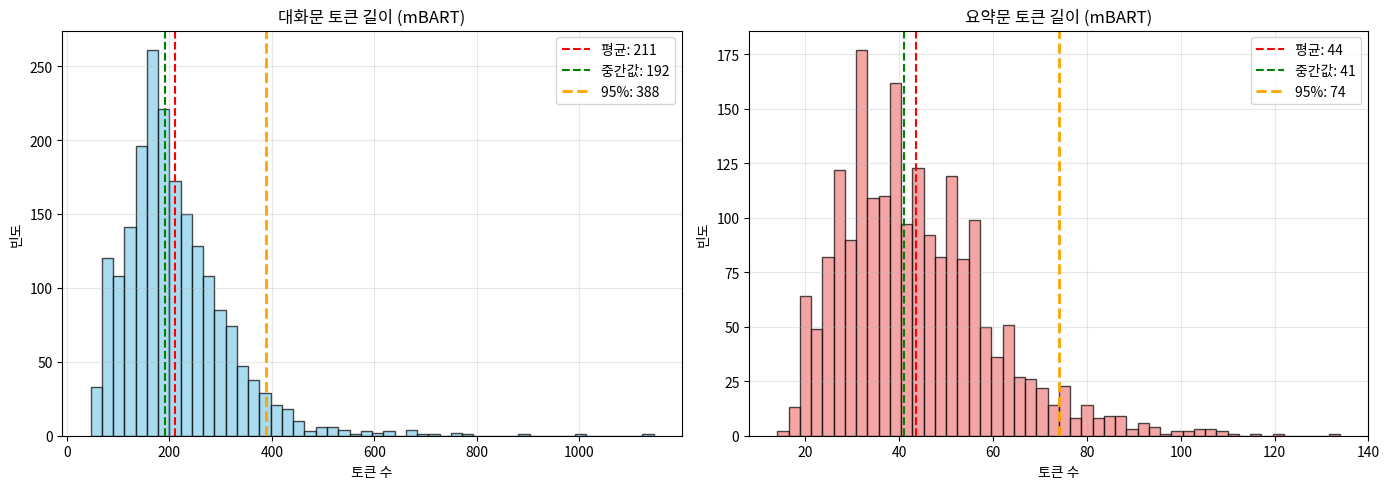

In [22]:
# mBART 토크나이저 로드
print("mBART 토크나이저 로딩 중...")
tokenizer = AutoTokenizer.from_pretrained("facebook/mbart-large-50", src_lang="ko_KR", tgt_lang="ko_KR")
print("✅ 완료!\n")

# ========================================
# 1. 실제 토큰 길이 분포 (가장 중요!)
# ========================================
print("=" * 60)
print("1. 실제 토큰 길이 분석 (mBART 기준)")
print("=" * 60)

# 샘플링 (전체 하면 시간 오래 걸림)
sample_size = 2000
print(f"샘플 {sample_size}개로 분석 중...")

sample_indices = np.random.choice(len(train), min(sample_size, len(train)), replace=False)

dialogue_token_lengths = []
summary_token_lengths = []

for idx in sample_indices:
    # 대화문 토큰화
    dialogue_tokens = tokenizer(
        train['dialogue'].iloc[idx], 
        truncation=False,
        add_special_tokens=True
    )
    dialogue_token_lengths.append(len(dialogue_tokens['input_ids']))
    
    # 요약문 토큰화
    summary_tokens = tokenizer(
        train['summary'].iloc[idx], 
        truncation=False,
        add_special_tokens=True
    )
    summary_token_lengths.append(len(summary_tokens['input_ids']))

dialogue_token_lengths = np.array(dialogue_token_lengths)
summary_token_lengths = np.array(summary_token_lengths)

# 통계 출력
print("\n[대화문 토큰 길이]")
print(f"평균: {dialogue_token_lengths.mean():.1f}")
print(f"중간값: {np.median(dialogue_token_lengths):.1f}")
print(f"표준편차: {dialogue_token_lengths.std():.1f}")
print(f"최소: {dialogue_token_lengths.min()}")
print(f"최대: {dialogue_token_lengths.max()}")
print(f"\nPercentiles:")
print(f"  50%: {np.percentile(dialogue_token_lengths, 50):.0f}")
print(f"  75%: {np.percentile(dialogue_token_lengths, 75):.0f}")
print(f"  90%: {np.percentile(dialogue_token_lengths, 90):.0f}")
print(f"  95%: {np.percentile(dialogue_token_lengths, 95):.0f}")
print(f"  99%: {np.percentile(dialogue_token_lengths, 99):.0f}")

print("\n[요약문 토큰 길이]")
print(f"평균: {summary_token_lengths.mean():.1f}")
print(f"중간값: {np.median(summary_token_lengths):.1f}")
print(f"표준편차: {summary_token_lengths.std():.1f}")
print(f"최소: {summary_token_lengths.min()}")
print(f"최대: {summary_token_lengths.max()}")
print(f"\nPercentiles:")
print(f"  50%: {np.percentile(summary_token_lengths, 50):.0f}")
print(f"  75%: {np.percentile(summary_token_lengths, 75):.0f}")
print(f"  90%: {np.percentile(summary_token_lengths, 90):.0f}")
print(f"  95%: {np.percentile(summary_token_lengths, 95):.0f}")
print(f"  99%: {np.percentile(summary_token_lengths, 99):.0f}")

# 권장 max_length 계산
recommended_source_length = int(np.percentile(dialogue_token_lengths, 95))
recommended_target_length = int(np.percentile(summary_token_lengths, 95))

print("\n" + "=" * 60)
print("🎯 권장 설정 (Right Skewed 고려)")
print("=" * 60)
print(f"max_source_length: {recommended_source_length} (95 percentile)")
print(f"max_target_length: {recommended_target_length} (95 percentile)")
print(f"\n이 설정으로 {sample_size}개 중:")
print(f"  - 대화문: {(dialogue_token_lengths <= recommended_source_length).sum()}개 ({(dialogue_token_lengths <= recommended_source_length).sum()/sample_size*100:.1f}%) 손실 없음")
print(f"  - 요약문: {(summary_token_lengths <= recommended_target_length).sum()}개 ({(summary_token_lengths <= recommended_target_length).sum()/sample_size*100:.1f}%) 손실 없음")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 대화문 토큰 길이
axes[0].hist(dialogue_token_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(dialogue_token_lengths.mean(), color='red', linestyle='--', label=f'평균: {dialogue_token_lengths.mean():.0f}')
axes[0].axvline(np.median(dialogue_token_lengths), color='green', linestyle='--', label=f'중간값: {np.median(dialogue_token_lengths):.0f}')
axes[0].axvline(recommended_source_length, color='orange', linestyle='--', linewidth=2, label=f'95%: {recommended_source_length}')
axes[0].set_title('대화문 토큰 길이 (mBART)')
axes[0].set_xlabel('토큰 수')
axes[0].set_ylabel('빈도')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 요약문 토큰 길이
axes[1].hist(summary_token_lengths, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].axvline(summary_token_lengths.mean(), color='red', linestyle='--', label=f'평균: {summary_token_lengths.mean():.0f}')
axes[1].axvline(np.median(summary_token_lengths), color='green', linestyle='--', label=f'중간값: {np.median(summary_token_lengths):.0f}')
axes[1].axvline(recommended_target_length, color='orange', linestyle='--', linewidth=2, label=f'95%: {recommended_target_length}')
axes[1].set_title('요약문 토큰 길이 (mBART)')
axes[1].set_xlabel('토큰 수')
axes[1].set_ylabel('빈도')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('token_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()



2. 대화 턴 수 분석

전체 턴 수 통계:
count    12457.000000
mean         9.487597
std          4.141391
min          2.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         59.000000
Name: total_turns, dtype: float64

3인 대화 비율:
  2인 대화: 12335개 (99.0%)
  3인 대화: 122개 (1.0%)


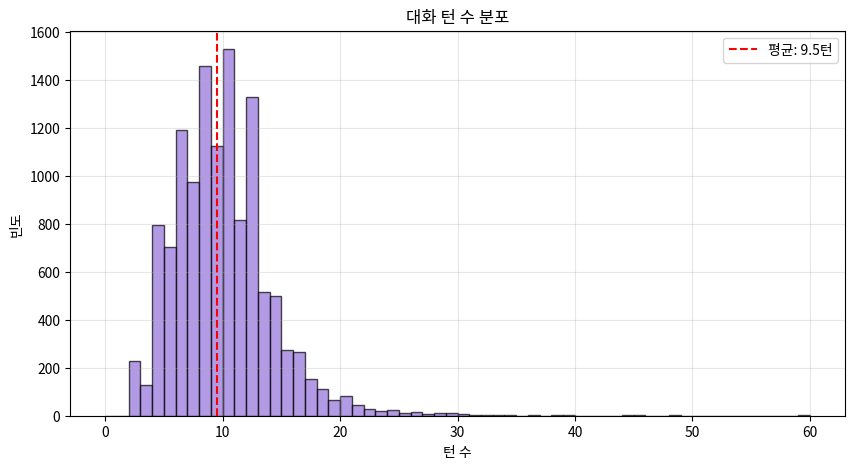

In [20]:
# ========================================
# 2. 대화 턴 수 분석
# ========================================
print("\n" + "=" * 60)
print("2. 대화 턴 수 분석")
print("=" * 60)

def count_turns(dialogue):
    """대화에서 Person1, Person2 등장 횟수 세기"""
    person1_count = len(re.findall(r'#Person1#', str(dialogue)))
    person2_count = len(re.findall(r'#Person2#', str(dialogue)))
    person3_count = len(re.findall(r'#Person3#', str(dialogue)))
    total_turns = person1_count + person2_count + person3_count
    return total_turns, person1_count, person2_count, person3_count

train['total_turns'] = train['dialogue'].apply(lambda x: count_turns(x)[0])
train['person1_turns'] = train['dialogue'].apply(lambda x: count_turns(x)[1])
train['person2_turns'] = train['dialogue'].apply(lambda x: count_turns(x)[2])
train['person3_turns'] = train['dialogue'].apply(lambda x: count_turns(x)[3])

print(f"\n전체 턴 수 통계:")
print(train['total_turns'].describe())

print(f"\n3인 대화 비율:")
print(f"  2인 대화: {(train['person3_turns'] == 0).sum()}개 ({(train['person3_turns'] == 0).sum()/len(train)*100:.1f}%)")
print(f"  3인 대화: {(train['person3_turns'] > 0).sum()}개 ({(train['person3_turns'] > 0).sum()/len(train)*100:.1f}%)")

# 턴 수 분포 시각화
plt.figure(figsize=(10, 5))
plt.hist(train['total_turns'], bins=range(0, train['total_turns'].max()+2), 
         color='mediumpurple', edgecolor='black', alpha=0.7)
plt.axvline(train['total_turns'].mean(), color='red', linestyle='--', 
            label=f'평균: {train["total_turns"].mean():.1f}턴')
plt.title('대화 턴 수 분포')
plt.xlabel('턴 수')
plt.ylabel('빈도')
plt.legend()
plt.grid(True, alpha=0.3)
#plt.savefig('turn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


3. Train vs Dev 분포 비교

데이터 크기:
  Train: 12457개
  Dev:   499개

대화문 길이 비교:
  Train 평균: 406.1
  Dev 평균:   400.1
  차이:       6.0

요약문 길이 비교:
  Train 평균: 85.8
  Dev 평균:   81.2
  차이:       4.6

토픽 수 비교:
  Train 유니크 토픽: 9235개
  Dev 유니크 토픽:   475개
  겹치는 토픽:       149개


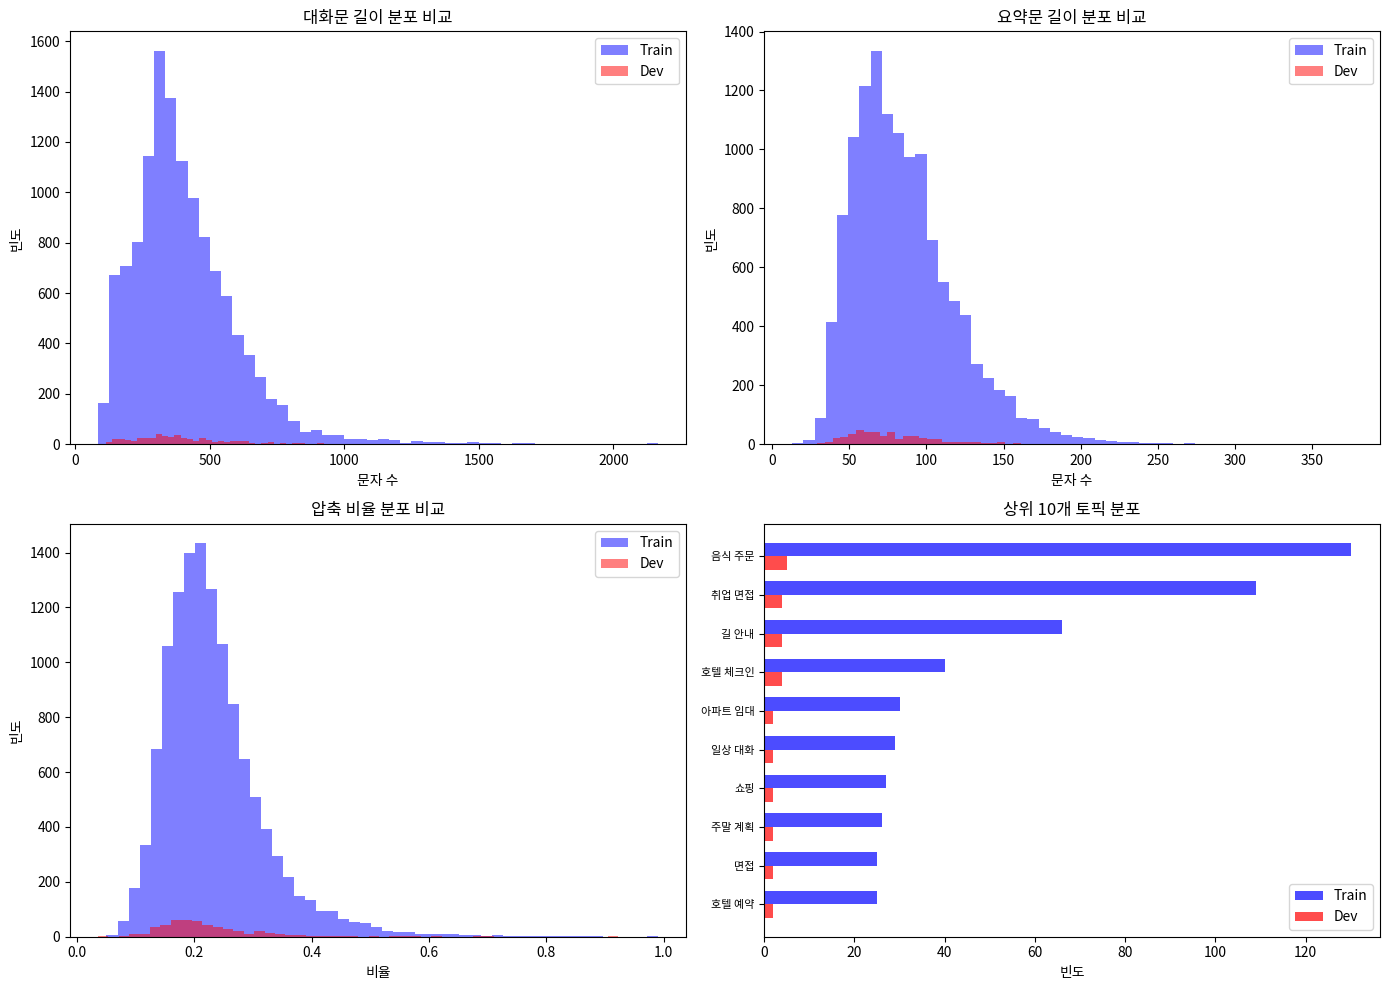

In [ ]:
# ========================================
# 3. Train vs Dev 분포 비교
# ========================================
print("\n" + "=" * 60)
print("3. Train vs Dev 분포 비교")
print("=" * 60)

# 길이 계산
dev['dialogue_len'] = dev['dialogue'].astype(str).apply(len)
dev['summary_len'] = dev['summary'].astype(str).apply(len)
train['dialogue_len'] = train['dialogue'].astype(str).apply(len)
train['summary_len'] = train['summary'].astype(str).apply(len)

print(f"\n데이터 크기:")
print(f"  Train: {len(train)}개")
print(f"  Dev:   {len(dev)}개")

print(f"\n대화문 길이 비교:")
print(f"  Train 평균: {train['dialogue_len'].mean():.1f}")
print(f"  Dev 평균:   {dev['dialogue_len'].mean():.1f}")
print(f"  차이:       {abs(train['dialogue_len'].mean() - dev['dialogue_len'].mean()):.1f}")

print(f"\n요약문 길이 비교:")
print(f"  Train 평균: {train['summary_len'].mean():.1f}")
print(f"  Dev 평균:   {dev['summary_len'].mean():.1f}")
print(f"  차이:       {abs(train['summary_len'].mean() - dev['summary_len'].mean()):.1f}")

# 토픽 분포 비교
train_topics = train['topic'].value_counts()
dev_topics = dev['topic'].value_counts()

print(f"\n토픽 수 비교:")
print(f"  Train 유니크 토픽: {len(train_topics)}개")
print(f"  Dev 유니크 토픽:   {len(dev_topics)}개")
print(f"  겹치는 토픽:       {len(set(train_topics.index) & set(dev_topics.index))}개")

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 대화문 길이 비교
axes[0, 0].hist(train['dialogue_len'], bins=50, alpha=0.5, label='Train', color='blue')
axes[0, 0].hist(dev['dialogue_len'], bins=50, alpha=0.5, label='Dev', color='red')
axes[0, 0].set_title('대화문 길이 분포 비교')
axes[0, 0].set_xlabel('문자 수')
axes[0, 0].set_ylabel('빈도')
axes[0, 0].legend()

# 요약문 길이 비교
axes[0, 1].hist(train['summary_len'], bins=50, alpha=0.5, label='Train', color='blue')
axes[0, 1].hist(dev['summary_len'], bins=50, alpha=0.5, label='Dev', color='red')
axes[0, 1].set_title('요약문 길이 분포 비교')
axes[0, 1].set_xlabel('문자 수')
axes[0, 1].set_ylabel('빈도')
axes[0, 1].legend()

# 압축 비율 비교
train['compression_ratio'] = train['summary_len'] / train['dialogue_len']
dev['compression_ratio'] = dev['summary_len'] / dev['dialogue_len']

axes[1, 0].hist(train['compression_ratio'], bins=50, alpha=0.5, label='Train', color='blue')
axes[1, 0].hist(dev['compression_ratio'], bins=50, alpha=0.5, label='Dev', color='red')
axes[1, 0].set_title('압축 비율 분포 비교')
axes[1, 0].set_xlabel('비율')
axes[1, 0].set_ylabel('빈도')
axes[1, 0].legend()

# 상위 토픽 비교
top_n = 10
top_train = train_topics.head(top_n)
top_dev = dev_topics.head(top_n)

x = np.arange(top_n)
width = 0.35

axes[1, 1].barh(x - width/2, top_train.values, width, label='Train', color='blue', alpha=0.7)
axes[1, 1].barh(x + width/2, top_dev.values, width, label='Dev', color='red', alpha=0.7)
axes[1, 1].set_yticks(x)
axes[1, 1].set_yticklabels(top_train.index, fontsize=8)
axes[1, 1].set_title(f'상위 {top_n}개 토픽 분포')
axes[1, 1].set_xlabel('빈도')
axes[1, 1].legend()
axes[1, 1].invert_yaxis()

plt.tight_layout()
#plt.savefig('train_dev_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

⚠️ 문제점:
text
Train 유니크 토픽: 9,235개
Dev 유니크 토픽:   475개
겹치는 토픽:       149개 (Dev의 31%만!)
이게 의미하는 것:

Dev의 69%는 Train에 없는 새로운 토픽

즉, 일반화 능력이 매우 중요!

토픽을 암기하는 게 아니라, 대화 → 요약 패턴을 학습해야 함

전략:

✅ 토픽 정보를 입력에 넣지 않음 (암기 방지)

✅ Data Augmentation 고려 (나중에)

✅ Regularization 강화 (Dropout, Weight Decay)

✅ 조기 종료(Early Stopping) 사용 (과적합 방지)

In [1]:
import pandas as pd

# train 데이터의 summary 패턴 분석
df = pd.read_csv("train.csv")

# #Person 패턴 비율 확인
person_pattern = df['summary'].str.contains('#Person', na=False).sum()
print(f"#Person 포함 비율: {person_pattern / len(df) * 100:.1f}%")

# 실제 샘플 10개 확인
print(df['summary'].head(10))


#Person 포함 비율: 85.9%
0    Mr. Smith는 Dr. Hawkins에게 건강검진을 받으러 와서, 매년 검진 필...
1    Mrs. Parker가 Ricky와 함께 백신 접종을 위해 방문하였고, Dr. Pe...
2    #Person1#은 열쇠 세트를 잃어버리고 #Person2#에게 찾는 것을 도와달라...
3    #Person1#은 #Person2#가 여자친구가 있고 결혼할 예정이라는 사실을 말...
4    Malik은 Wen과 Nikki에게 춤을 제안하고, Wen은 발을 밟는 것을 감수하...
5       Lisa가 Aims에게 생일 선물을 주었고, Aims는 그 선물을 매우 좋아합니다.
6                 #Person1#이 #Person2#에게 택시 요금을 설명합니다.
7    Judy Liao가 회계 보조직에 지원 중입니다. 그녀는 #Person1#에게 자신...
8    #Person1#은 #Person2#에게 기본 컴퓨터 패키지를 설명하며, #Pers...
9    #Person1#은 비자 담당자와의 인터뷰를 앞두고 있으며, #Person2#에게 ...
Name: summary, dtype: object


In [3]:
import pandas as pd
data = pd.read_csv("dev_predictions.csv")
onlyplot = data[['true_summary'] + ['pred_summary']]
onlyplot.to_csv("dev_onlyplot.csv", index=False)